In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('../functions')

# Read Data

In [3]:
data = pandas.read_csv('Data/hits.csv', index_col=0)
data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,Time,ELoss,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,250.000000,0.868600,0.868600,2581.1500,2581.1500,2581.1500,0,383.880371,5.310523e-06,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,249.507863,27.037487,-16.540384,3542.3793,3542.3793,3542.3793,0,415.954742,5.271870e-07,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,249.509850,-27.060200,16.517671,2592.3793,2592.3793,2592.3793,0,384.254303,3.097434e-06,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,249.203062,-23.553595,20.024276,2592.3793,2592.3793,2592.3793,1,384.251007,3.362202e-06,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,250.000000,-0.011400,-0.011400,2782.2500,2782.2500,2782.2500,0,390.597870,1.754228e-06,0


# Tests

In [4]:
from baseline import Baline
from reconstruction import TracksReconstruction2D
from combination import Combinator, MomentumCorrecter

from metrics import TracksReconstractionMetrics, CombinatorQuality

In [5]:
event = data[data.EventID == 3110]
event12 = event[(event.StatNb <= 2)*(event.ViewNb != 1)*(event.ViewNb != 2)]

x = event12.Wz1.values
y = event12.Wy1.values

In [6]:
#%%time
rt = Baline(n_max_hits=16, n_min_hits=3, window_width=0.2)

rt.fit(x, y)

labels = rt.labels_
tracks_params = rt.tracks_params_

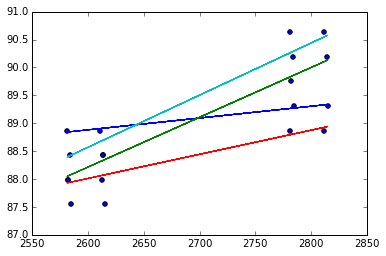

In [7]:
plt.scatter(x, y)
for n in range(len(tracks_params)):
    plt.plot(x, tracks_params[n][0] * x + tracks_params[n][1])
plt.show()

In [8]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency(eff_threshold=0.3)
hme.fit(event12.Label.values, labels)

hme.recognition_efficiency_

1.0

In [9]:
tracks_params

array([[  2.11418256e-03,   8.33845355e+01],
       [  8.92510170e-03,   6.50086756e+01],
       [  4.32592105e-03,   7.67628887e+01],
       [  9.34806177e-03,   6.42637582e+01]])

In [10]:
labels

array([ 1., -1.,  1., -1.,  2.,  2.,  1.,  3.,  0.,  2., -1.,  0.,  3.,
       -1.,  0.,  1.,  2.,  0.,  3.])

In [11]:
event12.Label.values

array([ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.])

# Stations 1&2

In [12]:
%%time
from multiprocessing import Pool
from utils import merge_dicts

event_ids = numpy.unique(data.EventID.values)

tracks = {}

#for event_id in event_ids:
def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None#1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None#1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    # Select model for the tracks reconstruction
    stm_y = Baline(n_max_hits=16, n_min_hits=7, window_width=0.7)
    stm_stereo = Baline(n_max_hits=16, n_min_hits=6, window_width=15)
    
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    one_track = {}
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    return one_track

if __name__ == "__main__":
    p = Pool(3)
    results = p.map(tracks_reconstruction, event_ids)
    tracks = merge_dicts(results)

CPU times: user 27.4 ms, sys: 14.4 ms, total: 41.7 ms
Wall time: 5.81 s


In [13]:
%%time
#event_ids = numpy.unique(data.EventID.values)

tracks12 = {}
tracks34 = {}
tracks_comb = {}
#tracks = {}

tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_true2 = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

for event_id in event_ids:
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    
    labels12 = tracks[event_id]['labels12']
    tracks_params12 = tracks[event_id]['params12']
    labels34 = tracks[event_id]['labels34']
    tracks_params34 = tracks[event_id]['params34']
    
    weights12 = None#1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None#1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
#     # Select model for the tracks reconstruction
#     stm_y = SimpleTemplateMatching(n_max_hits=16, n_min_hits=7, window_width=0.7)
#     stm_stereo = SimpleTemplateMatching(n_max_hits=16, n_min_hits=6, window_width=15)
    
    
#     # Tracks reconstruction before the magnet
#     tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
#     tr2d12.fit(event12, weights12)
    
#     labels12 = tr2d12.labels_
#     tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2)
    trm12.fit(labels12, event12)

    tracks_metrics_before_y.loc[len(tracks_metrics_before_y)] = [event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]

    tracks_metrics_before_stereo.loc[len(tracks_metrics_before_stereo)] = [event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

#     # Tracks reconstruction after the magnet
#     tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
#     tr2d34.fit(event34, weights34)
    
#     labels34 = tr2d34.labels_
#     tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_y.loc[len(tracks_metrics_after_y)] = [event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]

    tracks_metrics_after_stereo.loc[len(tracks_metrics_after_stereo)] = [event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
    
    # Save the reconstructed tracks
#     tracks[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
#                            'labels34':labels34, 'params34':tracks_params34}
    
    
    
    # Combination of the tracks before and after the magnet
    comb = Combinator()
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
        
    corr = MomentumCorrecter()
    corr.fit(labels12, labels34, comb.tracks_combinations_, event12, event34, weights12, weights34)
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    cq2 = CombinatorQuality()
    cq2.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, corr.inv_momentums_, event12, event34)
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_true)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]
        
        combinations_true2.loc[len(combinations_true2)] = [event_id, 
                                                               cq2.check_tracks_combinations_[num], 
                                                               cq2.true_pdg_codes_[num], 
                                                               cq2.true_charges_[num],
                                                               cq2.check_charges_[num], 
                                                               cq2.true_inv_momentums_[num], 
                                                               cq2.momentums_err_[num],
                                                               cq2.labels_[num]]

    
    
    # Overall quality
    line = numpy.array([1, 
                         (trm12.recognition_efficiency_y_ == 1)*1, 
                         (trm12.recognition_efficiency_stereo_ >= 1.)*1, 
                         (trm12.recognition_efficiency_ == 1)*1,
                         (trm34.recognition_efficiency_y_ == 1)*1, 
                         (trm34.recognition_efficiency_stereo_ >= 1.)*1, 
                         (trm34.recognition_efficiency_ == 1)*1, 
                         (cq.n_combined_ >= 2)*1,
                         (cq.reco_eff_ == 1)*1]).cumprod()
    pass_stages.loc[len(pass_stages)] = numpy.concatenate(([event_id], line), axis=0)
    
    # Save the tracks combination
    tracks_comb[event_id] = {'tracks_combinations':comb.tracks_combinations_, 
                             'charges':comb.charges_, 
                             'inv_momentums':comb.inv_momentums_}

CPU times: user 25.5 s, sys: 244 ms, total: 25.7 s
Wall time: 25.9 s


In [14]:
range(len(cq.check_tracks_combinations_))

[0, 1]

# Quality

# Stations 1&2

### Y-views

In [15]:
tracks_metrics_before_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.985774
RecoEff         0.988806
GhostRate       0.001493
CloneRate       0.005224
dtype: float64

### Stereo-views

In [16]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.981017
RecoEff         0.985075
GhostRate       0.001493
CloneRate       0.002239
dtype: float64

### Stations 1&2

In [17]:
tracks_metrics_before_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.982834
RecoEff         0.990299
GhostRate       0.001493
CloneRate       0.002985
dtype: float64

### Track efficiency

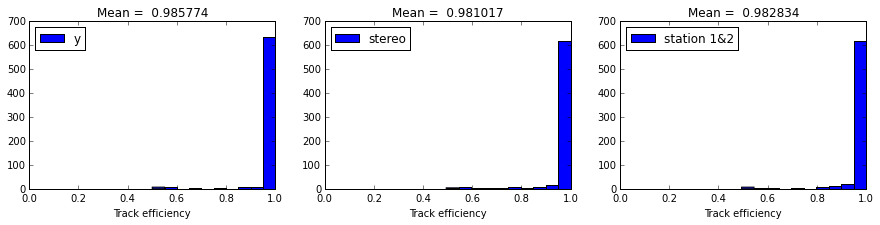

In [18]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

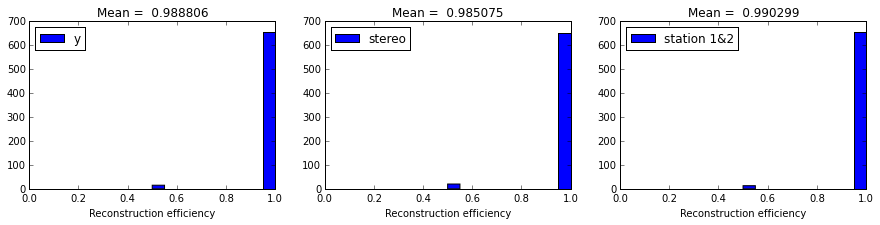

In [19]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [20]:
tracks_metrics_after_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.992310
RecoEff         0.991791
GhostRate       0.008209
CloneRate       0.001493
dtype: float64

### Stereo-views

In [21]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.985841
RecoEff         0.983582
GhostRate       0.008955
CloneRate       0.001493
dtype: float64

### Station 3&4

In [22]:
tracks_metrics_after_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.988682
RecoEff         0.988060
GhostRate       0.008209
CloneRate       0.000000
dtype: float64

### Tracks efficiency

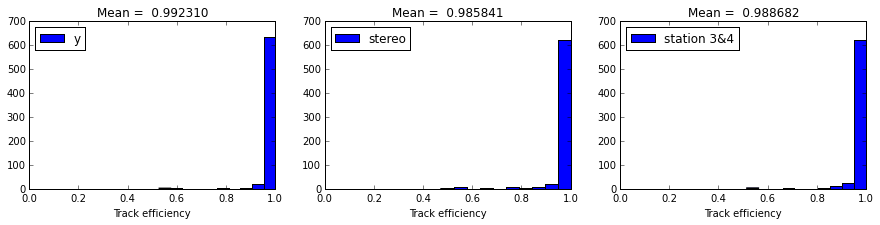

In [23]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

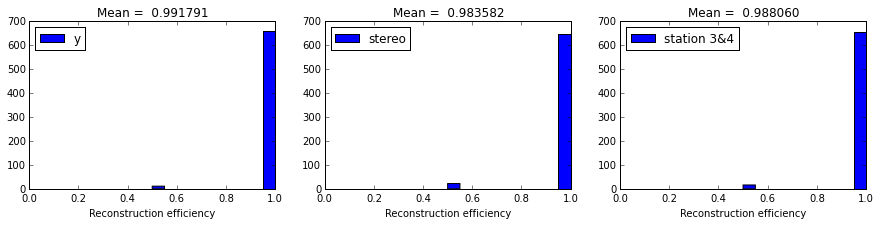

In [24]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [25]:
combinations_quality.mean(axis=0)

EventID      2555.164179
RecoEff         0.953731
GhostRate       0.001493
CloneRate       0.000000
NCombined       1.907463
dtype: float64

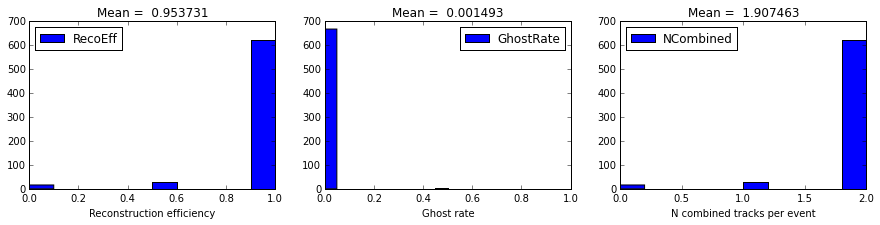

In [26]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

92.9850746269


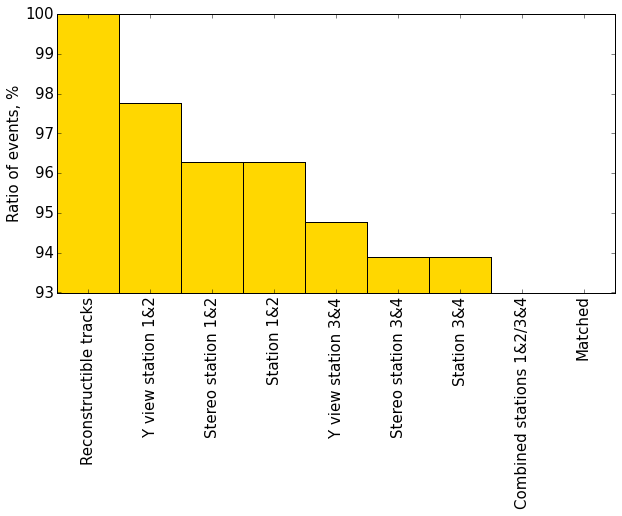

In [27]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages[pass_stages.columns[1:]].sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(10,5))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, size=15)
plt.yticks(size=15)
plt.xlim(-0.5, 8.5)
plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=15)
plt.show()

In [28]:
bar_values

array([ 100.        ,   97.76119403,   96.26865672,   96.26865672,
         94.7761194 ,   93.88059701,   93.88059701,   92.98507463,
         92.98507463])

In [29]:
#event_ids = numpy.unique(data.EventID.values)

def TotalEffVsTrackEff(event_ids, track_eff_cuts):

    total_efficiencies = []
    momentum_mae = []

    for cut in track_eff_cuts:

        combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                         'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

        pass_stages = pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                                'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

        for event_id in event_ids:

            # Get an event
            event = data[data.EventID == event_id]
            event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
            event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]


            labels12 = tracks[event_id]['labels12']
            tracks_params12 = tracks[event_id]['params12']
            labels34 = tracks[event_id]['labels34']
            tracks_params34 = tracks[event_id]['params34']

            # Quality metrics of the reconstruction
            trm12 = TracksReconstractionMetrics(cut)
            trm12.fit(labels12, event12)

            # Quality metrics of the reconstruction
            trm34 = TracksReconstractionMetrics(cut)
            trm34.fit(labels34, event34)

            # Combination of the tracks before and after the magnet
            comb = Combinator()
            comb.combine(tracks_params12, tracks_params34)


            # Quality of the combination
            cq = CombinatorQuality()
            cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)

            for num in range(len(cq.check_tracks_combinations_)):

                combinations_true.loc[len(combinations_quality)] = [event_id, 
                                                                       cq.check_tracks_combinations_[num], 
                                                                       cq.true_pdg_codes_[num], 
                                                                       cq.true_charges_[num],
                                                                       cq.check_charges_[num], 
                                                                       cq.true_inv_momentums_[num], 
                                                                       cq.momentums_err_[num],
                                                                       cq.labels_[num]]



            # Overall quality
            line = numpy.array([1, 
                                 (trm12.recognition_efficiency_y_ == 1)*1, 
                                 (trm12.recognition_efficiency_stereo_ >= 0.5)*1, 
                                 (trm12.recognition_efficiency_ == 1)*1,
                                 (trm34.recognition_efficiency_y_ == 1)*1, 
                                 (trm34.recognition_efficiency_stereo_ >= 0.5)*1, 
                                 (trm34.recognition_efficiency_ == 1)*1, 
                                 (cq.n_combined_ >= 2)*1,
                                 (cq.reco_eff_ == 1)*1]).cumprod()
            pass_stages.loc[len(pass_stages)] = numpy.concatenate(([event_id], line), axis=0)

        bar_values = pass_stages[pass_stages.columns[1:]].sum(axis=0).values
        bar_values = bar_values / bar_values[0] * 100

        total_eff = bar_values[-1]
        total_efficiencies.append(total_eff)
        
        passed_events = event_ids[pass_stages.Matching.values == 1]
        perr = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values
        ma_perr = numpy.abs(perr).mean() * 100
        momentum_mae.append(ma_perr)

    total_efficiencies = numpy.array(total_efficiencies)
    momentum_mae = numpy.array(momentum_mae)

    return total_efficiencies, momentum_mae

In [30]:
%%time
track_eff_cuts = numpy.linspace(0, 1., 21)
total_efficiencies, momentum_mae = TotalEffVsTrackEff(event_ids, track_eff_cuts)

CPU times: user 2min 2s, sys: 1.76 s, total: 2min 4s
Wall time: 2min 9s


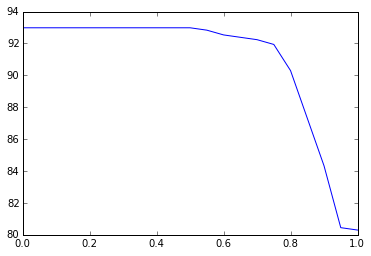

In [31]:
plt.plot(track_eff_cuts, total_efficiencies)
plt.show()

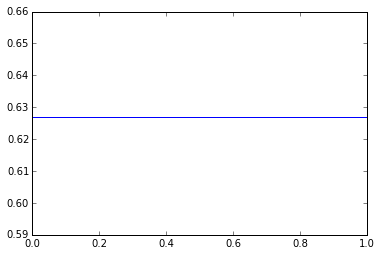

In [32]:
plt.plot(track_eff_cuts, momentum_mae)
plt.show()

# Momentum

In [33]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

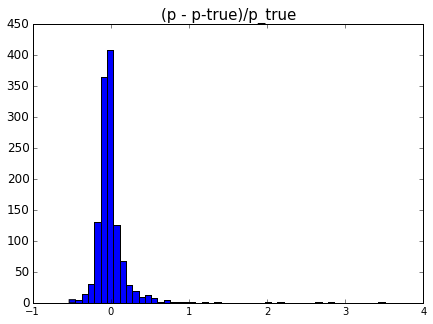

In [34]:
plt.figure(figsize=(7, 5))
plt.hist(p_err[numpy.isfinite(p_err)], bins=50)

plt.title('(p - p-true)/p_true', size=15)
#plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
#plt.xlim(-0.5, 0.5)
plt.show()

In [35]:
print numpy.abs(p_err).mean() * 100

11.7726281267


# Momentum2

In [36]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err2 = combinations_true2[combinations_true2.EventID.isin(passed_events)].PErr.values

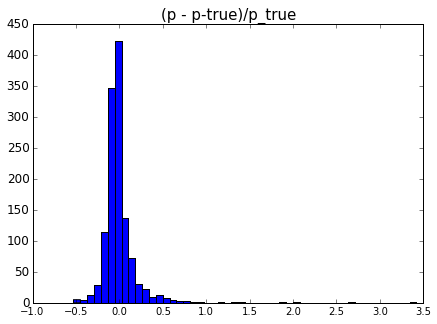

In [37]:
plt.figure(figsize=(7, 5))
plt.hist(p_err2[numpy.isfinite(p_err2)], bins=50)

plt.title('(p - p-true)/p_true', size=15)
#plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
#plt.xlim(-0.5, 0.5)
plt.show()

In [38]:
print numpy.abs(p_err2).mean() * 100

11.6824786597


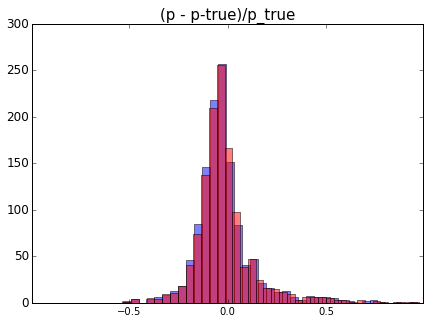

In [51]:
plt.figure(figsize=(7, 5))
plt.hist(p_err[numpy.isfinite(p_err)], bins=100, alpha=0.5, color='b')
plt.hist(p_err2[numpy.isfinite(p_err2)], bins=100, alpha=0.5, color='r')

plt.title('(p - p-true)/p_true', size=15)
#plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.99, 0.99)
plt.show()

In [40]:
combinations_true2[combinations_true2.PErr >= 0.3]

,EventID,IsTrueCombination,PdgCode,Charge,IsTrueCharge,TruePInv,PErr,Label
29,106,1,-13,1,1,0.026823,0.306459,1
34,126,1,211,1,1,0.014458,0.534945,0
103,449,1,-13,1,1,0.018461,0.310005,1
110,500,1,-13,1,1,0.015327,0.626765,1
127,606,1,-13,1,1,0.080178,0.581627,1
156,707,1,-211,-1,1,-0.016825,0.752300,0
161,735,1,211,1,1,0.018522,0.547976,0
173,777,1,211,1,1,0.021284,0.413096,0
224,927,1,-211,-1,1,-0.015920,0.692080,0
276,1157,1,-211,-1,1,-0.032660,0.328606,0


In [41]:
combinations_true[combinations_true.EventID == 1385]

,EventID,IsTrueCombination,PdgCode,Charge,IsTrueCharge,TruePInv,PErr,Label
351,1385,1,13,-1,1,-0.162050,0.743186,1
352,1385,1,211,1,1,0.029874,-0.053707,0


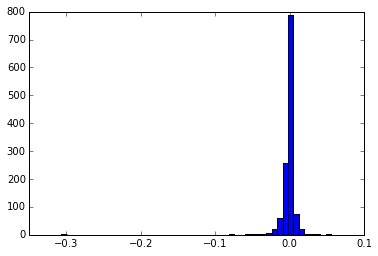

In [42]:
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values
p_err2 = combinations_true2[combinations_true2.EventID.isin(passed_events)].PErr.values

d = p_err2 - p_err

plt.hist(d, bins=50)
plt.show()

In [43]:
d.mean()

-0.0017970889630208656

# Efficiency per track

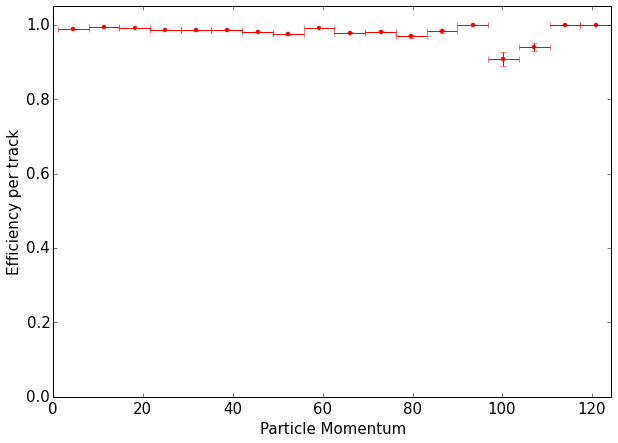

In [44]:
from utils import *

tracks_eff = get_effs_per_track_and_p(tracks, data, event_ids)

x_means, y_means, x_err, y_err = get_bins(tracks_eff.Momentum.values,
                                          tracks_eff.Eff.values,
                                          20,
                                          tracks_eff.Momentum.values.min(),
                                          tracks_eff.Momentum.values.max())

plt.figure(figsize=(10, 7))
plt.scatter(x_means, y_means, linewidth=0, color='r')
plt.errorbar(x_means, y_means, xerr=x_err, yerr=y_err, fmt='none', ecolor='r')
plt.ylim(0.0, 1.05)
plt.xlim(0, x_means[-3]+x_err[-3])
plt.xlabel('Particle Momentum', size=15)
plt.ylabel('Efficiency per track', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

# Did not recognized tracks

In [55]:
pass_stages[(pass_stages.Y12.values == 1)*(pass_stages.Stereo12.values == 0)]

,EventID,RecoEvents,Y12,Stereo12,Stations12,Y34,Stereo34,Stations34,Combination,Matching
38,270,1,1,0,0,0,0,0,0,0
133,1023,1,1,0,0,0,0,0,0,0
197,1528,1,1,0,0,0,0,0,0,0
220,1722,1,1,0,0,0,0,0,0,0
256,2040,1,1,0,0,0,0,0,0,0
353,2771,1,1,0,0,0,0,0,0,0
453,3406,1,1,0,0,0,0,0,0,0
489,3670,1,1,0,0,0,0,0,0,0
498,3749,1,1,0,0,0,0,0,0,0
502,3781,1,1,0,0,0,0,0,0,0


In [56]:
bad_events = pass_stages[(pass_stages.Y12.values == 1)*(pass_stages.Stereo12.values == 0)]['EventID'].values

270.0


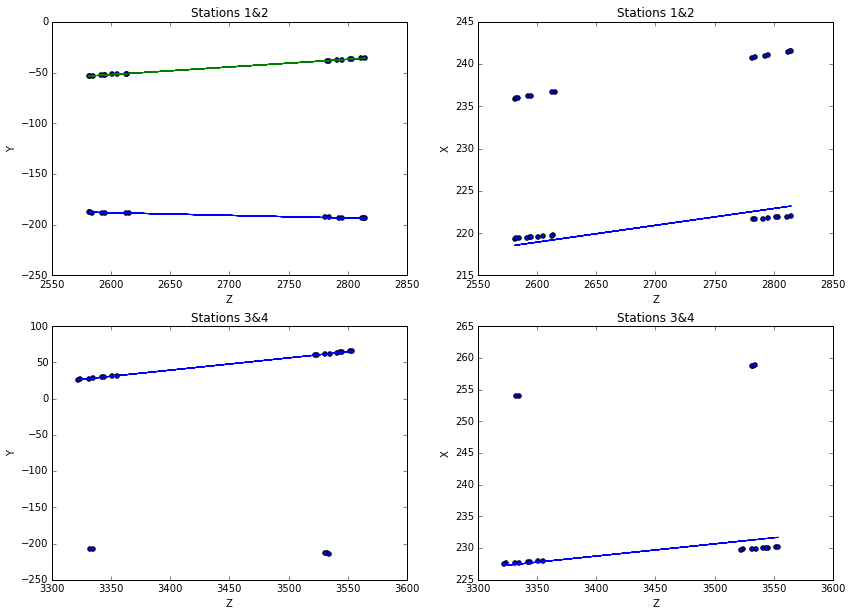

1023.0


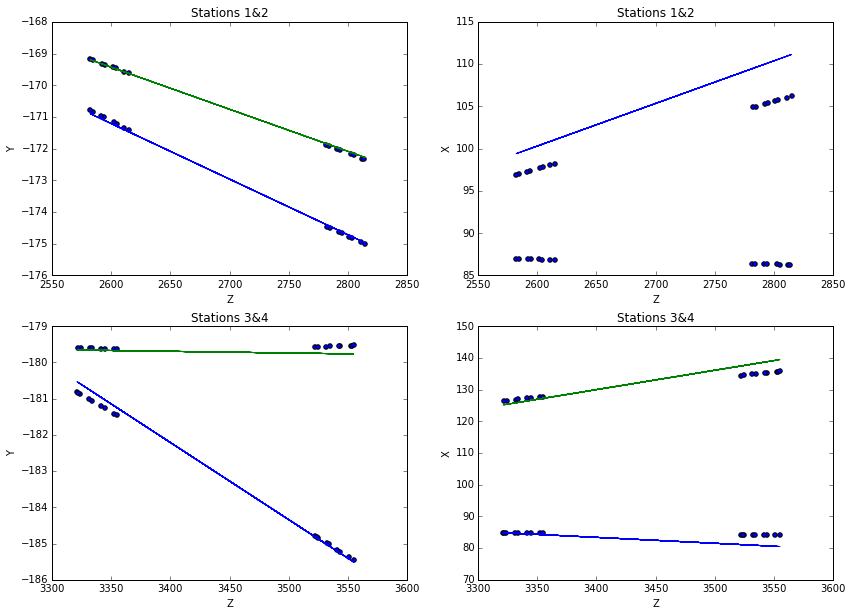

1528.0


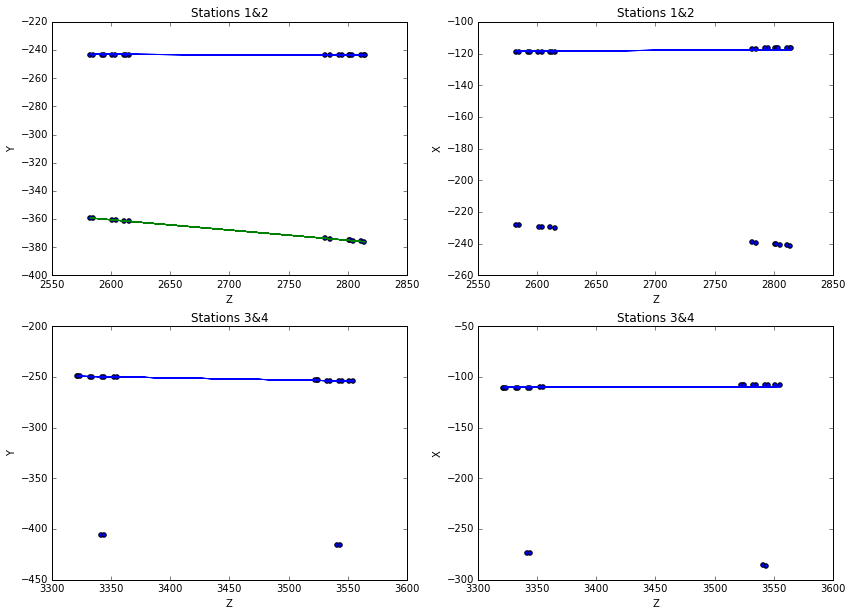

1722.0


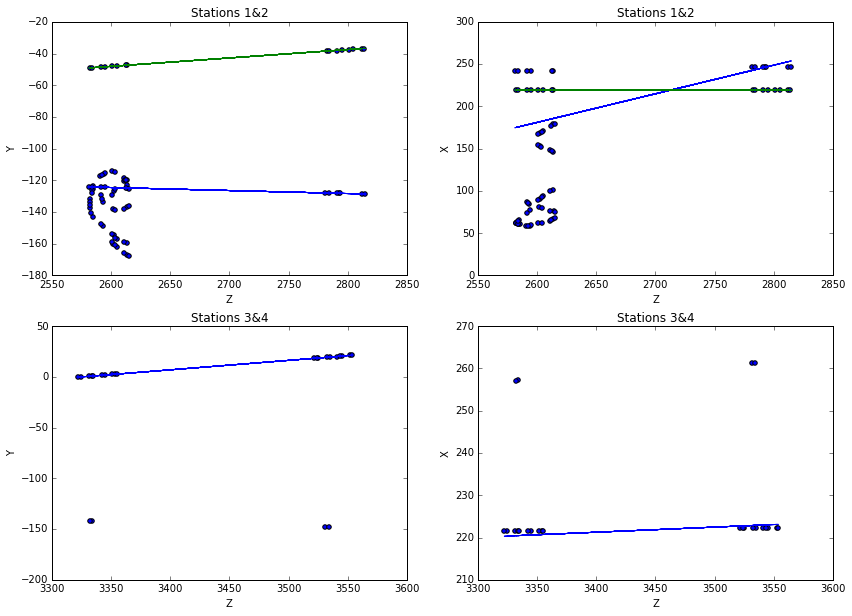

2040.0


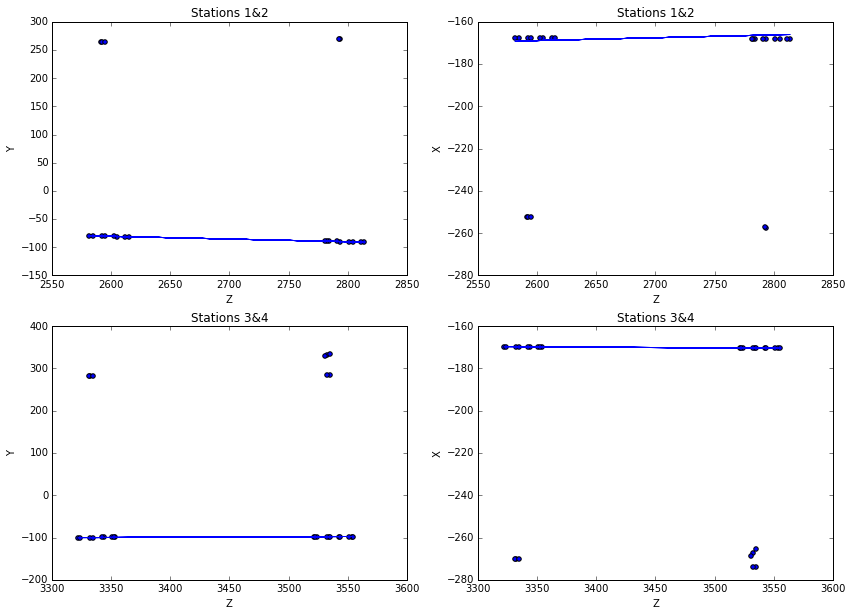

2771.0


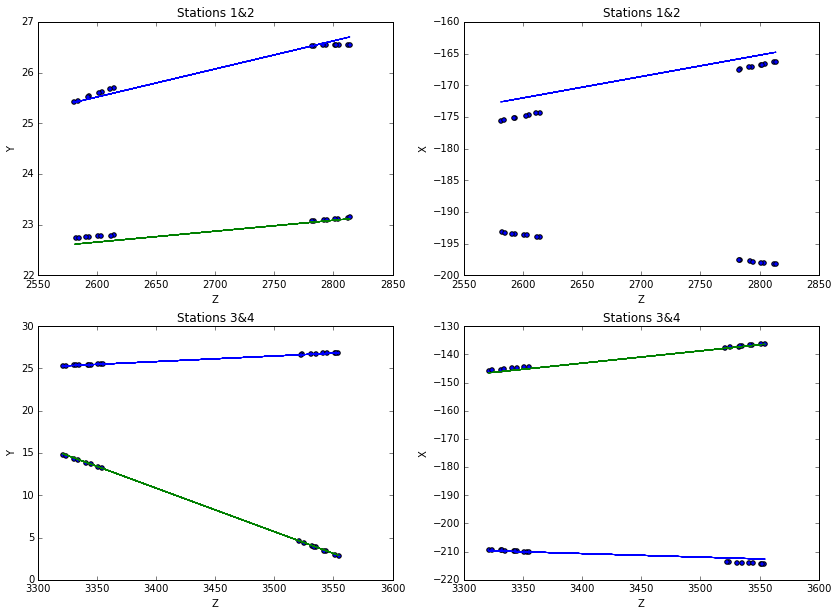

3406.0


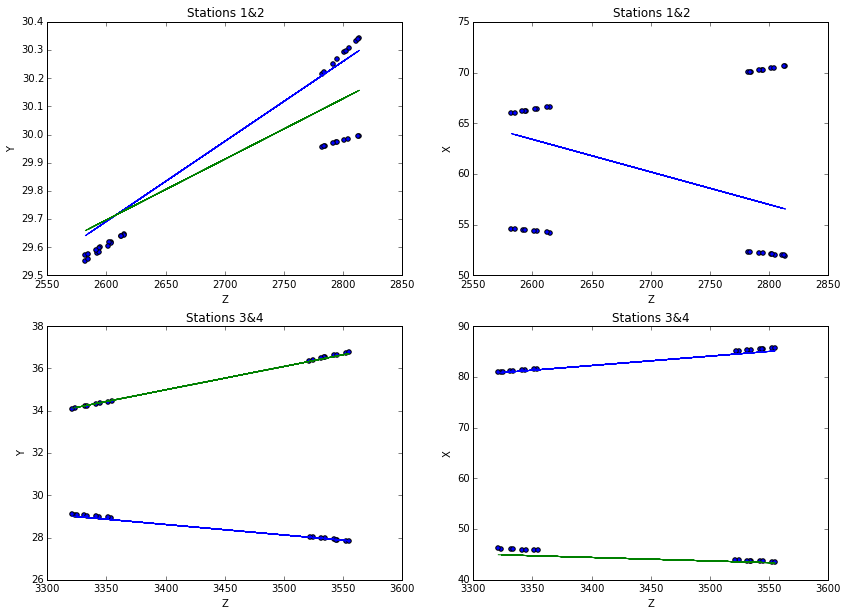

3670.0


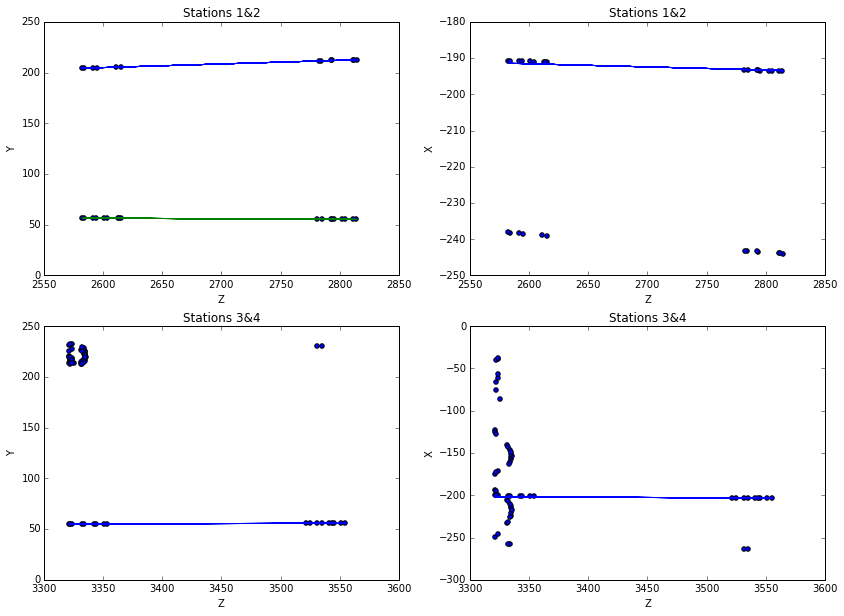

3749.0


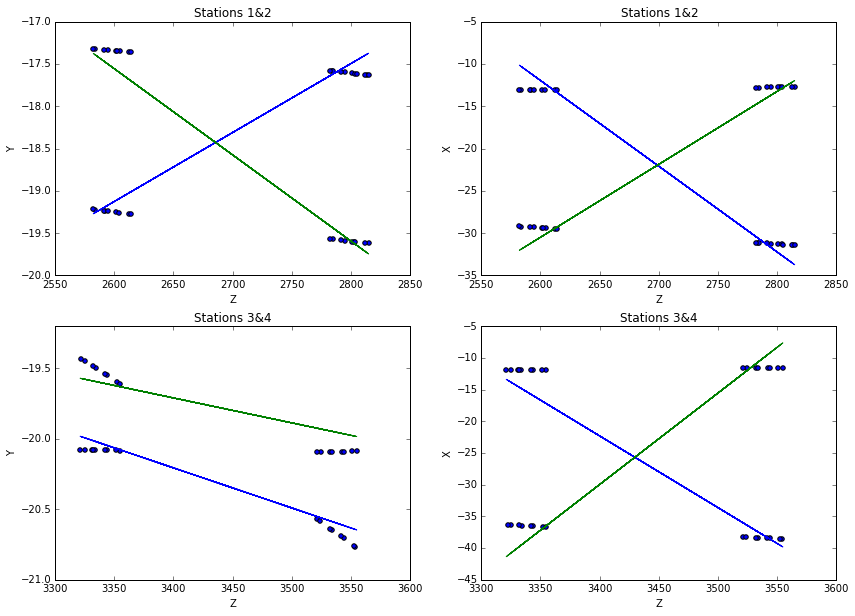

3781.0


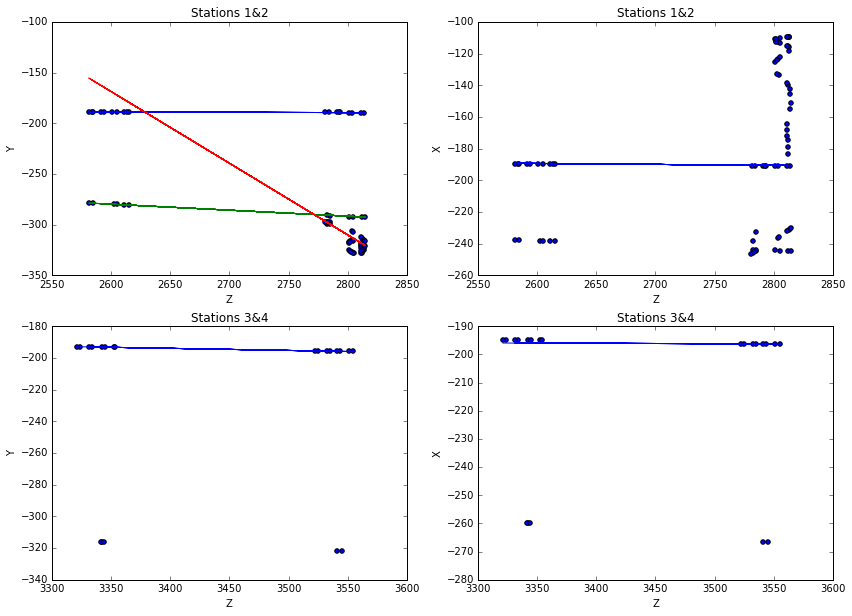

In [57]:
from utils import plot_event

for event_id in bad_events:
    print event_id
    plot_event(event_id, data, tracks)